In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import extract_features
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Here, we use L2 norm as the element comparison distance
l2_norm = lambda x, y: (x - y) ** 2


def slide_window(time_series, window_size, cur_loc=0, step=1):
    # print('Sliding Started')
    window_contents = []
    ts_len = len(time_series)
    while cur_loc + window_size <= ts_len:
        # print(time_series[cur_loc:cur_loc + window_size])
        window_contents.append(time_series[cur_loc:cur_loc + window_size])
        cur_loc += step
    # print('Sliding Completed')
    return window_contents


def find_signature_cycle(ts_list, num_consider=5):
    zip_ts = zip([len(ts) for ts in ts_list], ts_list)
    zip_ts = sorted(zip_ts, key=lambda x: x[0])
    length, ts_list_sorted = zip(*zip_ts)
    # print(length)
    signature = []
    short_ts = list(ts_list_sorted[:num_consider])
    len_limit = length[num_consider - 1]
    # print(len_limit)
    for i in range(len_limit):
        vertical_data_points = []
        for ts in short_ts:
            # print(ts)
            if i < len(ts):
                vertical_data_points.append(ts[i])
        avg = sum(vertical_data_points) / len(vertical_data_points)
        signature.append(avg)
    plt.plot(signature, color='k', label='avg signature cycle')
    plt.legend()
    return signature


def find_train_set_signature(train_file_name, label_name, num_cycles=10):
    df = pd.read_csv(train_file_name)
    df_all_cycles = df[df['label'] == label_name]
    ts_all = df['value']

    cycle_id = None
    ts_list = []
    ts = [0]
    for i in range(len(df_all_cycles)):
        row = df_all_cycles.iloc[i, :]
        val = row['value']
        if row['cycle_id'] != cycle_id:
            plt.plot(ts, alpha=0.6)
            ts_list.append(ts)
            ts = []
            cycle_id = row['cycle_id']
            ts.append(val)
        else:
            ts.append(val)
    
    signature = find_signature_cycle(ts_list, num_consider=num_cycles)
    return signature
    


def sliding_window_dtw(all_window_contents, signature):
    dist_list = []
    path_list = []
    marker_1 = []
    marker_2 = []
    for slide in all_window_contents:
        # print(slide.tolist())
        slide_l = slide.tolist()
        dist, cost_matrix, acc_cost_matrix, path = dtw(signature, slide_l, dist=l2_norm)
        path_list.append(path)
        dist_list.append(dist)
    return dist_list, path_list


def split_train_test(X, y, pca=False):
    if pca:
        extract_features_normalized = preprocessing.normalize(X)

        pca = decomposition.PCA(n_components=len(extract_features_normalized))
        principalComponents = pca.fit_transform(extract_features_normalized)
        principalDf = pd.DataFrame(data=principalComponents)
        print('cumulative sums of explained variance ratio:')
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        print(cumsum)

        n_components = next(x for x, val in enumerate(cumsum) if val > 0.97) + 1
        print('To make explained variance ratio >= 0.97, \
         we choose n_components of PCA to be:', n_components)

        pca_ = decomposition.PCA(n_components=n_components)
        principalComponents_ = pca_.fit_transform(extract_features_normalized)
        X = pd.DataFrame(data=principalComponents_)
        # print('shape of reduced extract features is: ', principalDf_.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, random_state=0)
    return X_train, y_train, X_test, y_test


def test_feature_extract(df, target_name='A',
                         value_column='value', id_column='cycle_id',
                         time_column='time_index'):
    from tsfresh.feature_extraction import ComprehensiveFCParameters
    from tsfresh.feature_extraction import extract_features
    from tsfresh import extract_relevant_features

    # Select columns
    df_ = df[[value_column, id_column, time_column]]

    # tsfresh feature extraction
    df_.sort_values(by=['time_index'])
    features_delta = extract_features(df_.drop(columns=[time_column]),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id=id_column)

    # delete columns with inf value
    valid_column = list(np.isfinite(features_delta).all())
    # X = features_delta.iloc[:, valid_column]
    # X.replace([np.inf, -np.inf], np.nan, inplace=True)
    # X = X.fillna(0, inplace=True)

    X = features_delta

    return X, valid_column


def train_feature_extract(file_name, target_name='A', label_column='label',
                          value_column='value', id_column='cycle_id',
                          time_column='time_index', ):
    from tsfresh.feature_extraction import ComprehensiveFCParameters
    from tsfresh.feature_extraction import extract_features
    from tsfresh import extract_relevant_features

    df = pd.read_csv(file_name)
    # Select columns
    df_ = df[[label_column, value_column, id_column, time_column]]

    # tsfresh feature extraction
    df_.sort_values(by=['time_index'])
    features_delta = extract_features(df_.drop(columns=[label_column, time_column]),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id=id_column)
    # Get 0,1 labels
    grouped = df_.groupby([id_column])
    labels = grouped.first()[label_column]
    labels = [1 if x == target_name else 0 for x in labels]

    # delete columns with inf value
    valid_column = list(np.isfinite(features_delta).all())
    # features_delta = features_delta.iloc[:, valid_column]

    X = features_delta
    y = labels

    return X, y, valid_column


def train_decision_tree(X_train, y_train, X_test, y_test):
    # Cross Validation
    clf = tree.DecisionTreeClassifier(max_depth=5)
    param_grid = {"max_depth": [3, 4, 5, 6, 7, 8]}

    grid_search2 = GridSearchCV(clf, param_grid=param_grid,
                                scoring='accuracy', cv=5,
                                return_train_score=True)
    grid_search2.fit(X_train, y_train)
    print("Scores on validation set:")
    means = grid_search2.cv_results_['mean_test_score']
    stds = grid_search2.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,
                                 grid_search2.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print(grid_search2.best_params_)

    # Return model with best hyper parameters
    print('==============================')
    clf = tree.DecisionTreeClassifier(max_depth=grid_search2.best_params_['max_depth'])
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('Scores on testing set:', score)
    return clf


def train_random_forest(X_train, y_train, X_test, y_test):
    # Create Random Forest Regressor object
    rf = RandomForestClassifier(random_state=10)

    param_grid = {"criterion": ['entropy', 'gini'],
                  "n_estimators": [10, 20],
                  "max_depth": [3, 5, 7, 10]}

    grid_search = GridSearchCV(rf, param_grid=param_grid,
                               scoring='accuracy', cv=10,
                               return_train_score=True)
    grid_search.fit(X_train, y_train)

    print("Scores on validation set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,
                                 grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print(grid_search.best_params_)

    # Return model with best hyper parameters
    print('==============================')
    rf = RandomForestClassifier(criterion=grid_search.best_params_['criterion'],
                                n_estimators=grid_search.best_params_['n_estimators'],
                                max_depth=grid_search.best_params_['max_depth'])
    rf = rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    print('Scores on testing set:', score)
    return rf


def train_decision_tree_no_test(X_train, y_train):
    # Cross Validation
    clf = tree.DecisionTreeClassifier()
    param_grid = {"max_depth": [3, 4, 5, 6, 7, 8]}

    grid_search2 = GridSearchCV(clf, param_grid=param_grid,
                                scoring='accuracy', cv=5,
                                return_train_score=True)
    
    grid_search2.fit(X_train, y_train)
    print("Train decision tree...:")
    print("Scores on validation set:")
    means = grid_search2.cv_results_['mean_test_score']
    stds = grid_search2.cv_results_['std_test_score']
    
#     for mean, std, params in zip(means, stds,
#                                  grid_search2.cv_results_['params']):
# #         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print('Validation Results -- grid search best parameters: ', grid_search2.best_params_)
    
    clf = tree.DecisionTreeClassifier(max_depth=grid_search2.best_params_['max_depth'])
    clf = clf.fit(X_train, y_train)
    return clf


def train_random_forest_no_test(X_train, y_train):
    # Create Random Forest Regressor object
    rf = RandomForestClassifier(random_state=10)

    param_grid = {"criterion": ['entropy', 'gini'],
                  "n_estimators": [10, 20],
                  "max_depth": [3, 5, 7, 10]}

    grid_search = GridSearchCV(rf, param_grid=param_grid,
                               scoring='accuracy', cv=5,
                               return_train_score=True)
    
    grid_search.fit(X_train, y_train)
#     print("Train random forest...:")
#     print("Scores on validation set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds,
#                                  grid_search.cv_results_['params']):
# #         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print('Validation Results -- grid search best parameters: ', grid_search.best_params_)

    # Return model with best hyper parameters
#     print('==============================')
    rf = RandomForestClassifier(criterion=grid_search.best_params_['criterion'],
                                n_estimators=grid_search.best_params_['n_estimators'],
                                max_depth=grid_search.best_params_['max_depth'])
    rf = rf.fit(X_train, y_train)
    return rf


def construct_cycle_id(ts_list):
    rep_times = [len(ts) for ts in ts_list]
    cycle_id = []
    id_ = 0
    for i in rep_times:
        cycle_id.append([id_] * i)
        id_ += 1
    cycle_id = [i for j in cycle_id for i in j]
    return cycle_id




def sliding_window_find_dist(file_name, label_name, signature, generate_plots=False):
    df = pd.read_csv(file_name)
    df_all_cycles = df[df['label'] == label_name]
    ts_all = df['value']

    all_window_contents = slide_window(ts_all, 45, step=1)

    dist_list, path_list = sliding_window_dtw(all_window_contents, signature)

    grouped = df_all_cycles.groupby(['cycle_id'])
    cycle_labels = grouped.first()['time_index']
    cycle_labels_2 = grouped.last()['time_index']

    if generate_plots:
        plt.figure(figsize=(60, 5))
        plt.plot(dist_list[:], label='distance to signature cycle')
        plt.plot(ts_all[:], color='k', label='input time series')
        plt.ylim(-2, 8)
        start = cycle_labels.tolist()
        end = cycle_labels_2.tolist()
        for i in cycle_labels:
            plt.axvline(i, 0, 14, linestyle='--', color='r')
        for i in range(len(start)):
            # alpha: 透明度
            # i+.5 -- 宽度
            plt.axvspan(start[i], end[i], facecolor='r', alpha=0.3)
        plt.legend()

    return ts_all, all_window_contents, dist_list, path_list, \
           cycle_labels, cycle_labels_2


def sliding_window_classifier(all_window_contents, dist_list, train_file_name,
                              target_name, dtw_threshold,
                              classifier='rf', predict_type='proba'):
    # Step 0: remove all partial time series if dist > dtw_threshold
    #         we only do classification on valid pieces
    #         - where dist is smaller than threshold
    index_list = [i for i, bol in enumerate([i < dtw_threshold for i in dist_list]) if bol]
    valid_pieces = [all_window_contents[i] for i in index_list]

    # Preprocess windowcontents into the df
    # as the input of extract_features
    valid_pieces_flatten = [item for sublist in valid_pieces for item in sublist]
    cycle_id = construct_cycle_id(valid_pieces)
    df_test = pd.DataFrame({'time_index': [i for i in range(len(valid_pieces_flatten))],
                            'value': valid_pieces_flatten,
                            'cycle_id': cycle_id})

    # Step 1: feature extraction on test dataset
    features_delta = extract_features(df_test.drop(columns=['time_index']),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id='cycle_id')

    # Step 2: preprocess train and test set. find all invalid columns, and remove
    #         them from both train and test sets.
    X_test = features_delta
    valid_column_test = list(np.isfinite(features_delta).all())

    X_train, y_train, valid_column_train = train_feature_extract(train_file_name,
                                                                 target_name=target_name)
    valid_column = np.logical_and(valid_column_train, valid_column_test)

    X_train = X_train.iloc[:, valid_column]
    X_test = X_test.iloc[:, valid_column]

    # Step 3: train model/classifier on training set
    if classifier == 'rf':
        print('Training random forest classifier...')
        model = train_random_forest_no_test(X_train, y_train)
    elif classifier == 'clf':
        print('Training decision tree classifier...')
        model = train_decision_tree_no_test(X_train, y_train)
    else: 
        print('classifier type not availabel.')
        return 'Select classifier rf or clf'

    # step 4: calculate prediction
    print('Calculating prediction... prediction type: ', predict_type)
    if predict_type == 'proba':
        model_pred = model.predict_proba(X_test)[:, 1]

    elif predict_type == 'binary':
        model_pred = model.predict(X_test)

#     print(len(model_pred))
#     print(model_pred)
#     print(np.mean(model_pred))

    total_len = len(dist_list)
    proba_list = [0] * total_len

    for i in index_list:
        proba_list[i] = model_pred[0]
        model_pred = model_pred[1:]

    return proba_list


def find_dtw_threshold(dist_list, percentile):
#     plt.hist(dist_list, bins=20)
#     plt.show()
    suggested_threshold = np.percentile(dist_list, percentile)
    return suggested_threshold


def plot_result(dist_list, ts_all, proba_list, threshold, cycle_start, cycle_end):
    plt.figure(figsize=(60, 5))
    plt.plot(dist_list[:], label='distance to signature cycle')
    plt.plot(ts_all[:], color='k', label='input time series')
    plt.plot(np.array(proba_list) * 10, color='g', label='random forest proba to be cycle')
    start = cycle_start.tolist()
    end = cycle_end.tolist()
    for i in cycle_start:
        plt.axvline(i, 0, 14, linestyle='--', color='r')
    for i in range(len(start)):
        # alpha: 透明度
        # i+.5 -- 宽度
        plt.axvspan(start[i], end[i], facecolor='r', alpha=0.15)
    plt.axhline(threshold, 0, 14, linestyle='--', label='dtw 50 percentile threshold')
    plt.axhline(10, 0, 14, linestyle='dotted', color='g', label='max confidence(x10)')
    plt.legend()


# Main Function
def run_model(train_file_name, test_file_name,
              target_name, dtw_filter_percentile=50,
              generate_report=True, generate_plot=True):
    
    print('Find signature cycle from training set ...')
    signature = find_train_set_signature(train_file_name, target_name)
    
    print('Sliding window on testing time series ...')
    print('Calculating DTW distance')
    sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
    ts_all = sliding_window_results[0]
    all_window_contents = sliding_window_results[1]
    dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
    cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]
    
    print('Looking for DTW distance threshold ...')
    print('percentile:', dtw_filter_percentile)
    suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)
    
    print('Converting time series to features by feature extraction...')
    proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                           train_file_name, target_name,
                                           suggested_threshold)

    plot_result(dist_list, ts_all, proba_list,
                suggested_threshold, cycle_start, cycle_end)

    

def find_local_max(proba_list, threshold, range_filter):
    predicted_cycle_start, _ = find_peaks(proba_list, height=threshold, distance=range_filter)
    plt.figure(figsize=(35, 3))
    plt.plot(proba_list, color='g', alpha=0.6)
    for i in predicted_cycle_start:
        plt.axvline(i, 0, 14, color='b')
    plt.show()
    return predicted_cycle_start

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Training classifier


Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


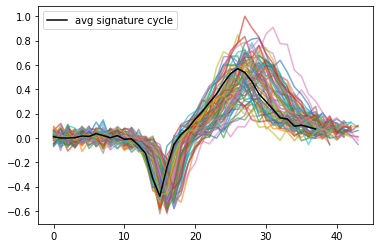

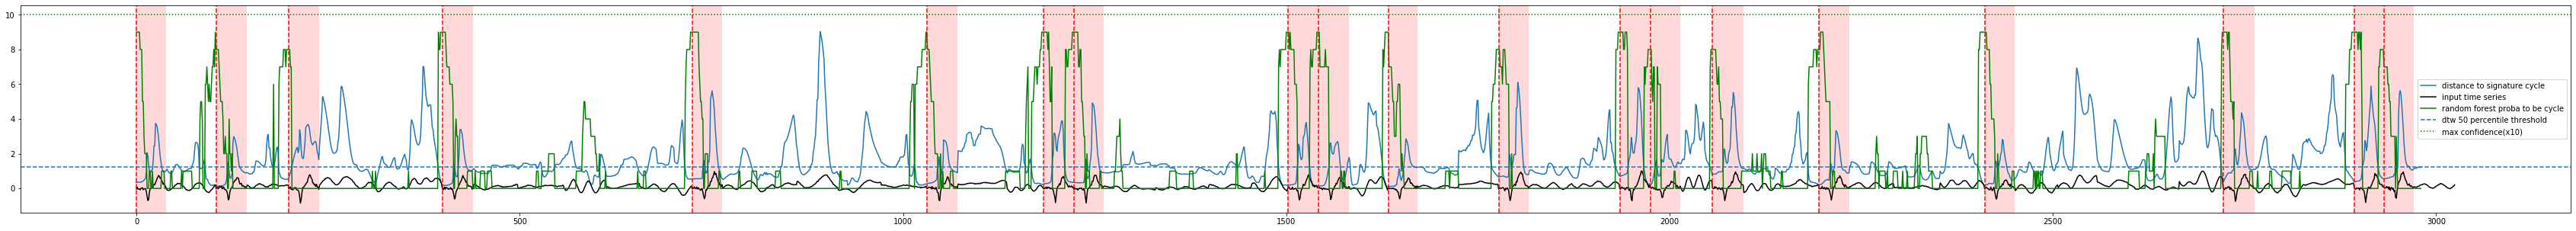

In [9]:
run_model('E_train_1.csv', 'E_test_1.csv',
              'B', dtw_filter_percentile=50,
              generate_report=True, generate_plot=True)

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Training classifier


Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


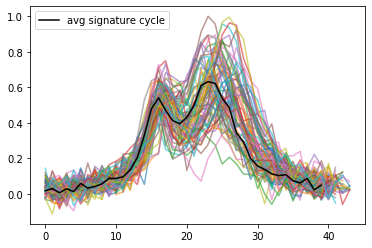

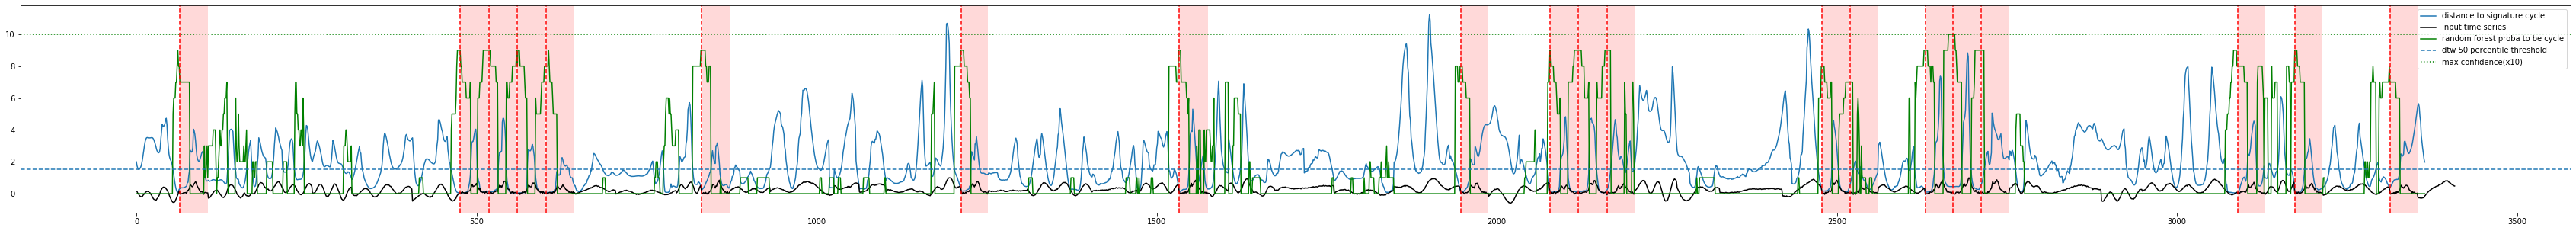

In [10]:
run_model('F_train_1.csv', 'F_test_1.csv',
              'B', dtw_filter_percentile=50,
              generate_report=True, generate_plot=True)

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...


Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


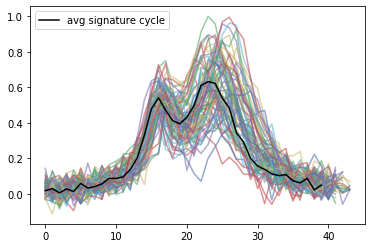

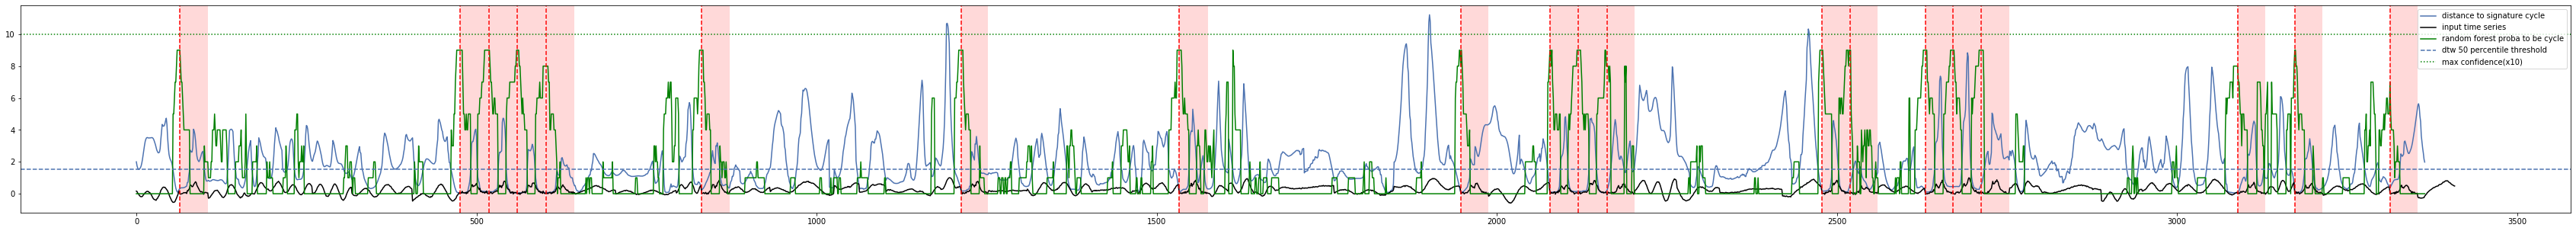

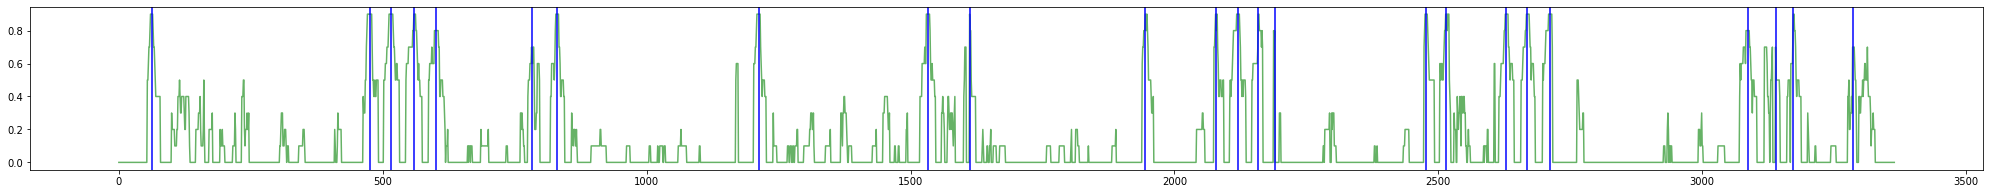

array([  62,  475,  515,  560,  601,  782,  830, 1212, 1533, 1612, 1945,
       2078, 2120, 2159, 2190, 2477, 2515, 2629, 2669, 2712, 3086, 3139,
       3173, 3286])

In [264]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'F_train_1.csv' 
test_file_name = 'F_test_1.csv'
target_name = 'B'
dtw_filter_percentile = 50
generate_report, generate_plot = True, True


print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.7
range_filter = 30
find_local_max(proba_list, threshold, range_filter)

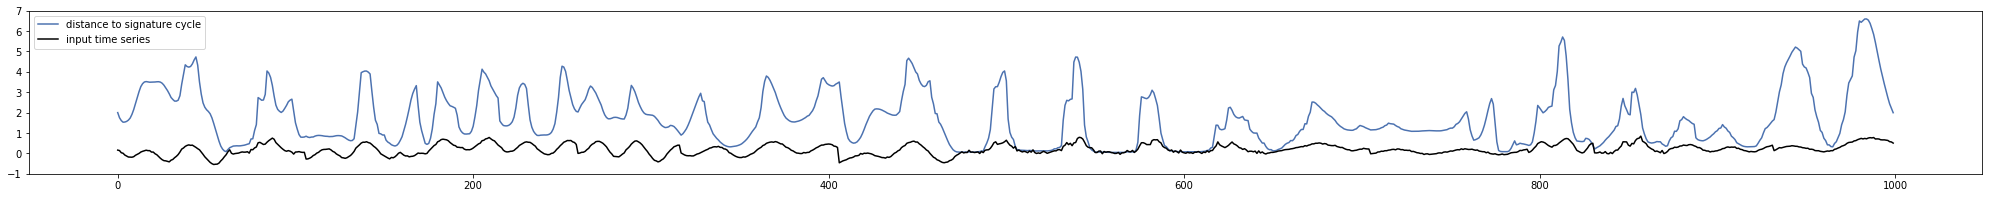

In [81]:
plt.figure(figsize=(35, 3))
plt.plot(dist_list[:1000], label='distance to signature cycle')
plt.plot(ts_all[:1000], color='k', label='input time series')
plt.ylim(-1, 7)

# for i in cycle_start:
#     if i < 1000:
#         #plt.axvline(i, 0, 14, linestyle='--', color='r')
# for i in range(len(cycle_start)):
#     # alpha: 透明度
#     # i+.5 -- 宽度
#     if cycle_start.tolist()[i] <1000:
#         #plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
plt.legend()

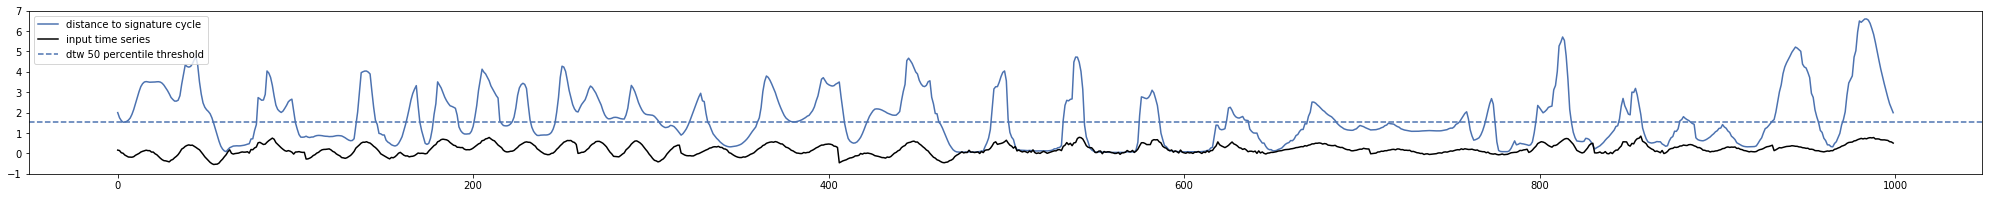

In [83]:
plt.figure(figsize=(35, 3))
plt.plot(dist_list[:1000], label='distance to signature cycle')
plt.plot(ts_all[:1000], color='k', label='input time series')
plt.ylim(-1, 7)

# for i in cycle_start:
#     if i < 1000:
#         #plt.axvline(i, 0, 14, linestyle='--', color='r')
# for i in range(len(cycle_start)):
#     # alpha: 透明度
#     # i+.5 -- 宽度
#     if cycle_start.tolist()[i] <1000:
#         #plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
plt.axhline(suggested_threshold, 0, 14, linestyle='--', label='dtw 50 percentile threshold')
plt.legend()



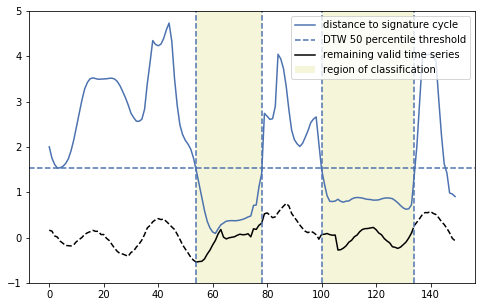

In [114]:
plt.figure(figsize=(8, 5))

plt.plot(ts_all[0:55], color='k', linestyle = '--')
plt.plot(dist_list[:150], label='distance to signature cycle')
plt.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')
plt.plot(ts_all[54:80], color='k', label='remaining valid time series')
plt.plot(ts_all[79:100], color='k', linestyle = '--')
plt.plot(ts_all[99:134], color='k')
plt.plot(ts_all[133:150], color='k', linestyle = '--')

plt.ylim(-1, 5)

# for i in cycle_start:
#     if i < 1000:
#         #plt.axvline(i, 0, 14, linestyle='--', color='r')
# for i in range(len(cycle_start)):
#     # alpha: 透明度
#     # i+.5 -- 宽度
#     if cycle_start.tolist()[i] <1000:
#         #plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
plt.axvline(54, 0, 14, linestyle='--')
plt.axvline(78, 0, 14, linestyle='--')
plt.axvline(100, 0, 14, linestyle='--')
plt.axvline(134, 0, 14, linestyle='--')

plt.axvspan(54, 78, facecolor='y', alpha=0.15)
plt.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')

plt.legend()

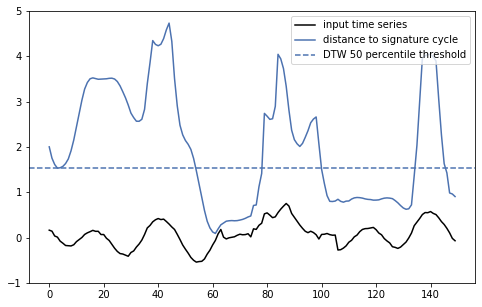

In [115]:
plt.figure(figsize=(8, 5))

plt.plot(ts_all[0:150], color='k', label='input time series')
plt.plot(dist_list[:150], label='distance to signature cycle')
plt.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')
# plt.plot(ts_all[54:80], color='k', label='remaining valid time series')
# plt.plot(ts_all[79:100], color='k', linestyle = '--')
# plt.plot(ts_all[99:137], color='k')
# plt.plot(ts_all[136:150], color='k', linestyle = '--')

plt.ylim(-1, 5)

# for i in cycle_start:
#     if i < 1000:
#         #plt.axvline(i, 0, 14, linestyle='--', color='r')
# for i in range(len(cycle_start)):
#     # alpha: 透明度
#     # i+.5 -- 宽度
#     if cycle_start.tolist()[i] <1000:
#         #plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
# plt.axvline(54, 0, 14, linestyle='--')
# plt.axvline(78, 0, 14, linestyle='--')
# plt.axvline(100, 0, 14, linestyle='--')
# plt.axvline(134, 0, 14, linestyle='--')

# plt.axvspan(54, 78, facecolor='y', alpha=0.15)
# plt.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')

plt.legend()

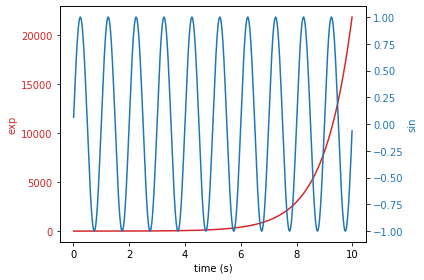

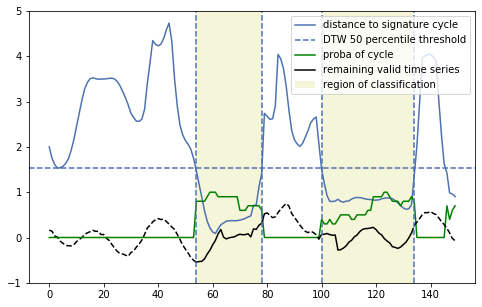

In [119]:
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




plt.figure(figsize=(8, 5))

plt.plot(ts_all[0:55], color='k', linestyle = '--')
plt.plot(dist_list[:150], label='distance to signature cycle')
plt.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')
plt.plot(proba_list[:150], color = 'g', label='proba of cycle')
plt.plot(ts_all[54:80], color='k', label='remaining valid time series')
plt.plot(ts_all[79:100], color='k', linestyle = '--')
plt.plot(ts_all[99:134], color='k')
plt.plot(ts_all[133:150], color='k', linestyle = '--')

plt.ylim(-1, 5)

# for i in cycle_start:
#     if i < 1000:
#         #plt.axvline(i, 0, 14, linestyle='--', color='r')
# for i in range(len(cycle_start)):
#     # alpha: 透明度
#     # i+.5 -- 宽度
#     if cycle_start.tolist()[i] <1000:
#         #plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
plt.axvline(54, 0, 14, linestyle='--')
plt.axvline(78, 0, 14, linestyle='--')
plt.axvline(100, 0, 14, linestyle='--')
plt.axvline(134, 0, 14, linestyle='--')

plt.axvspan(54, 78, facecolor='y', alpha=0.15)
plt.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')

plt.legend()

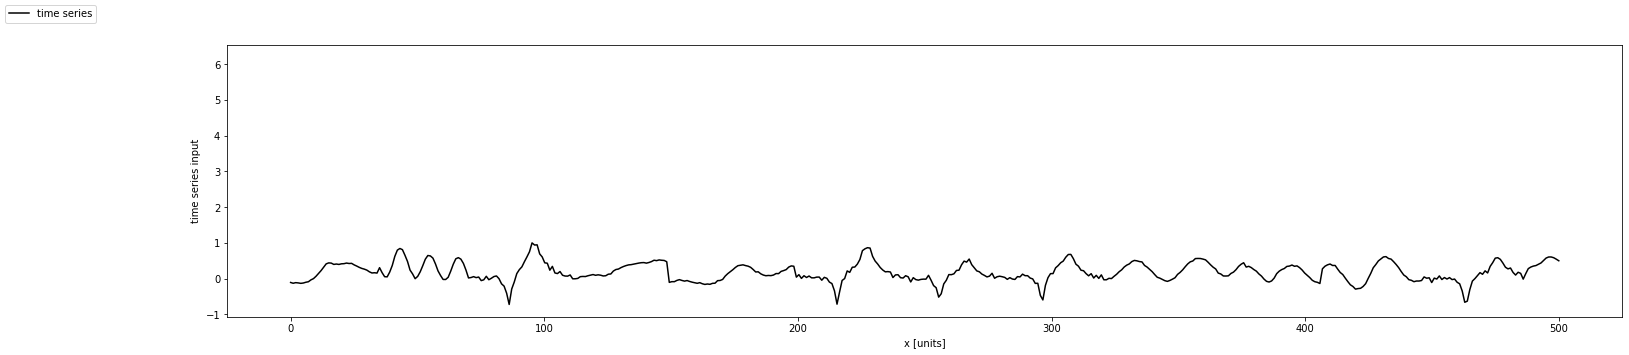

In [226]:
x = np.linspace(0,500,500)
y1 = ts_all[0:500]
y2 = dist_list[:500]

z = proba_list[:500]

fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:500], alpha=0)
#ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(54, 0, 14, linestyle='--')
# ax.axvline(79, 0, 14, linestyle='--')
# ax.axvline(100, 0, 14, linestyle='--')
# ax.axvline(135, 0, 14, linestyle='--')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


#ax2 = ax.twinx()
#ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

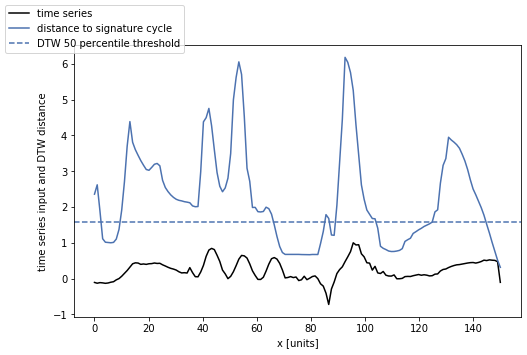

In [195]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150], label='distance to signature cycle')
ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(54, 0, 14, linestyle='--')
# ax.axvline(79, 0, 14, linestyle='--')
# ax.axvline(100, 0, 14, linestyle='--')
# ax.axvline(135, 0, 14, linestyle='--')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


#ax2 = ax.twinx()
#ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

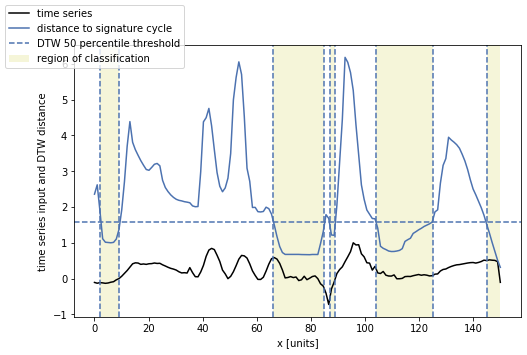

In [204]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150], label='distance to signature cycle')
ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

ax.axvline(2, 0, 14, linestyle='--')
ax.axvline(9, 0, 14, linestyle='--')
ax.axvline(66, 0, 14, linestyle='--')
ax.axvline(85, 0, 14, linestyle='--')
ax.axvline(87, 0, 14, linestyle='--')
ax.axvline(89, 0, 14, linestyle='--')
ax.axvline(104, 0, 14, linestyle='--')
ax.axvline(125, 0, 14, linestyle='--')
ax.axvline(145, 0, 14, linestyle='--')

ax.axvspan(2, 9, facecolor='y', alpha=0.15)
ax.axvspan(66, 85, facecolor='y', alpha=0.15, label='region of classification')
ax.axvspan(87, 89, facecolor='y', alpha=0.15)
ax.axvspan(104, 125, facecolor='y', alpha=0.15)
ax.axvspan(145, 150, facecolor='y', alpha=0.15)




# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


#ax2 = ax.twinx()
ax2.plot(x,z[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

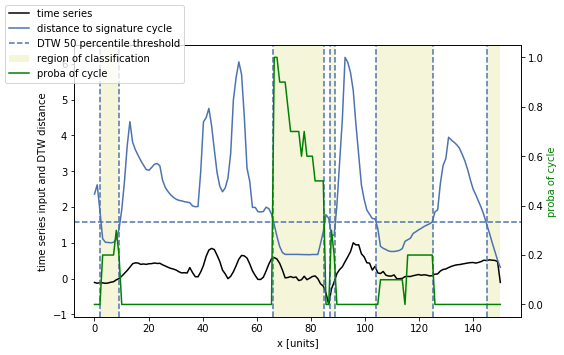

In [208]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150], label='distance to signature cycle')
ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

ax.axvline(2, 0, 14, linestyle='--')
ax.axvline(9, 0, 14, linestyle='--')
ax.axvline(66, 0, 14, linestyle='--')
ax.axvline(85, 0, 14, linestyle='--')
ax.axvline(87, 0, 14, linestyle='--')
ax.axvline(89, 0, 14, linestyle='--')
ax.axvline(104, 0, 14, linestyle='--')
ax.axvline(125, 0, 14, linestyle='--')
ax.axvline(145, 0, 14, linestyle='--')

ax.axvspan(2, 9, facecolor='y', alpha=0.15)
ax.axvspan(66, 85, facecolor='y', alpha=0.15, label='region of classification')
ax.axvspan(87, 89, facecolor='y', alpha=0.15)
ax.axvspan(104, 125, facecolor='y', alpha=0.15)
ax.axvspan(145, 150, facecolor='y', alpha=0.15)




# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


ax2 = ax.twinx()
ax2.plot(x,z[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

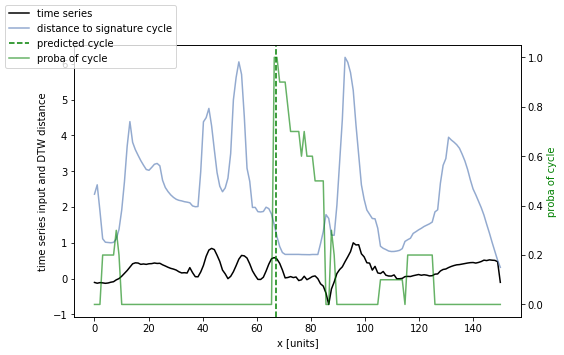

In [215]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150], label='distance to signature cycle',alpha=0.6)
# ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(2, 0, 14, linestyle='--')
# ax.axvline(9, 0, 14, linestyle='--')
# ax.axvline(66, 0, 14, linestyle='--')
# ax.axvline(85, 0, 14, linestyle='--')
# ax.axvline(87, 0, 14, linestyle='--')
# ax.axvline(89, 0, 14, linestyle='--')
# ax.axvline(104, 0, 14, linestyle='--')
# ax.axvline(125, 0, 14, linestyle='--')
# ax.axvline(145, 0, 14, linestyle='--')

# ax.axvspan(2, 9, facecolor='y', alpha=0.15)
# ax.axvspan(66, 85, facecolor='y', alpha=0.15, label='region of classification')
# ax.axvspan(87, 89, facecolor='y', alpha=0.15)
# ax.axvspan(104, 125, facecolor='y', alpha=0.15)
# ax.axvspan(145, 150, facecolor='y', alpha=0.15)


ax.axvline(67, 0, 14, linestyle='--', color='g', label='predicted cycle')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


ax2 = ax.twinx()
ax2.plot(x,z[:150], color = 'g', label='proba of cycle', alpha=0.6)
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

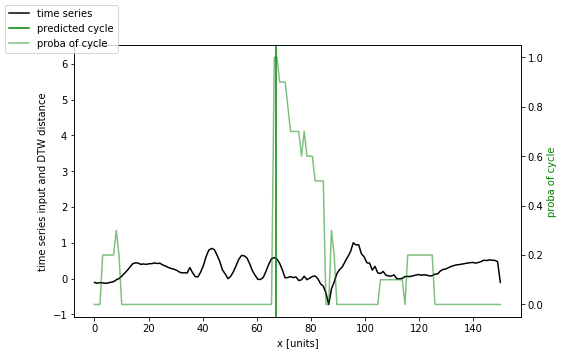

In [222]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150],alpha=0)
# ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(2, 0, 14, linestyle='--')
# ax.axvline(9, 0, 14, linestyle='--')
# ax.axvline(66, 0, 14, linestyle='--')
# ax.axvline(85, 0, 14, linestyle='--')
# ax.axvline(87, 0, 14, linestyle='--')
# ax.axvline(89, 0, 14, linestyle='--')
# ax.axvline(104, 0, 14, linestyle='--')
# ax.axvline(125, 0, 14, linestyle='--')
# ax.axvline(145, 0, 14, linestyle='--')

# ax.axvspan(2, 9, facecolor='y', alpha=0.15)
# ax.axvspan(66, 85, facecolor='y', alpha=0.15, label='region of classification')
# ax.axvspan(87, 89, facecolor='y', alpha=0.15)
# ax.axvspan(104, 125, facecolor='y', alpha=0.15)
# ax.axvspan(145, 150, facecolor='y', alpha=0.15)


ax.axvline(67, 0, 14, color='g', label='predicted cycle')
#ax.axvline(cycle_start.tolist()[0], 0, 14, color='r', label='true cycle')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


ax2 = ax.twinx()
ax2.plot(x,z[:150], color = 'g', label='proba of cycle', alpha=0.5)
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

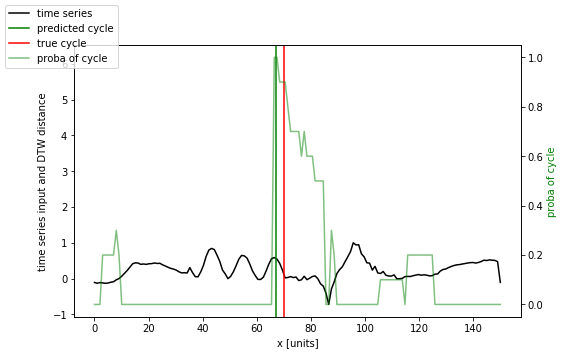

In [218]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150],alpha=0)
# ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(2, 0, 14, linestyle='--')
# ax.axvline(9, 0, 14, linestyle='--')
# ax.axvline(66, 0, 14, linestyle='--')
# ax.axvline(85, 0, 14, linestyle='--')
# ax.axvline(87, 0, 14, linestyle='--')
# ax.axvline(89, 0, 14, linestyle='--')
# ax.axvline(104, 0, 14, linestyle='--')
# ax.axvline(125, 0, 14, linestyle='--')
# ax.axvline(145, 0, 14, linestyle='--')

# ax.axvspan(2, 9, facecolor='y', alpha=0.15)
# ax.axvspan(66, 85, facecolor='y', alpha=0.15, label='region of classification')
# ax.axvspan(87, 89, facecolor='y', alpha=0.15)
# ax.axvspan(104, 125, facecolor='y', alpha=0.15)
# ax.axvspan(145, 150, facecolor='y', alpha=0.15)


ax.axvline(67, 0, 14, color='g', label='predicted cycle')
ax.axvline(cycle_start.tolist()[0], 0, 14, color='r', label='true cycle')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


ax2 = ax.twinx()
ax2.plot(x,z[:150], color = 'g', label='proba of cycle', alpha=0.5)
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()

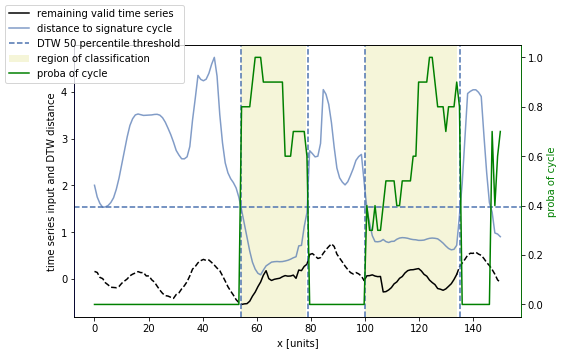

In [146]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x[0:55],y1[0:55], color='k', linestyle = '--')
ax.plot(x[54:80],y1[54:80], color='k', label='remaining valid time series')
ax.plot(x[79:100],y1[79:100], color='k', linestyle = '--')
ax.plot(x[99:134],y1[99:134], color='k')
ax.plot(x[133:150],y1[133:150], color='k', linestyle = '--')

ax.plot(x, dist_list[:150], label='distance to signature cycle', a;)
ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

ax.axvline(54, 0, 14, linestyle='--')
ax.axvline(79, 0, 14, linestyle='--')
ax.axvline(100, 0, 14, linestyle='--')
ax.axvline(135, 0, 14, linestyle='--')

ax.axvspan(54, 78, facecolor='y', alpha=0.15)
ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


ax2 = ax.twinx()
ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
ax2.spines['right'].set_color('g')
plt.show()


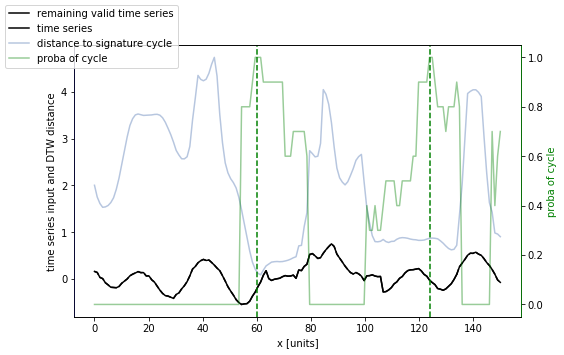

In [168]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x[0:55],y1[0:55], color='k', linestyle = '--')
ax.plot(x[54:80],y1[54:80], color='k', label='remaining valid time series')
ax.plot(x[79:100],y1[79:100], color='k', linestyle = '--')
ax.plot(x[99:134],y1[99:134], color='k')
ax.plot(x[133:150],y1[133:150], color='k', linestyle = '--')

ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list[:150], label='distance to signature cycle', alpha=0.4)
# ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(54, 0, 14, linestyle='--')
# ax.axvline(79, 0, 14, linestyle='--')
# ax.axvline(100, 0, 14, linestyle='--')
# ax.axvline(135, 0, 14, linestyle='--')

# ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')

ax.axvline(60, 0, 14, linestyle='--', color='g')
ax.axvline(124, 0, 14, linestyle='--', color='g')

ax2 = ax.twinx()
ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle', alpha=0.4)
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
ax2.spines['right'].set_color('g')
plt.show()


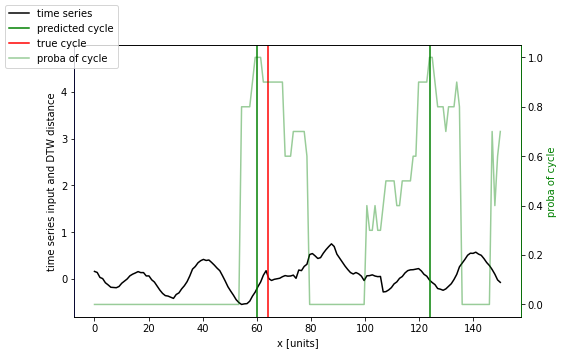

In [180]:
x = np.linspace(0,150,150)
y1 = ts_all[0:150]
y2 = dist_list[:150]

z = proba_list[:150]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
# ax.plot(x[0:55],y1[0:55], color='k', linestyle = '--')
# ax.plot(x[54:80],y1[54:80], color='k', label='remaining valid time series')
# ax.plot(x[79:100],y1[79:100], color='k', linestyle = '--')
# ax.plot(x[99:134],y1[99:134], color='k')
# ax.plot(x[133:150],y1[133:150], color='k', linestyle = '--')

ax.plot(x,y1, color='k', label='time series')

ax2 = ax.twinx()
ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle', alpha=0.4)

ax.plot(x, dist_list[:150], alpha=0)
# ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(54, 0, 14, linestyle='--')
# ax.axvline(79, 0, 14, linestyle='--')
# ax.axvline(100, 0, 14, linestyle='--')
# ax.axvline(135, 0, 14, linestyle='--')

# ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')

ax.axvline(60, 0, 14, color='g',  label='predicted cycle')
ax.axvline(124, 0, 14, color='g')

ax.axvline(cycle_start.tolist()[0], 0, 14, color='r', label='true cycle')

fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
ax2.spines['right'].set_color('g')
plt.show()



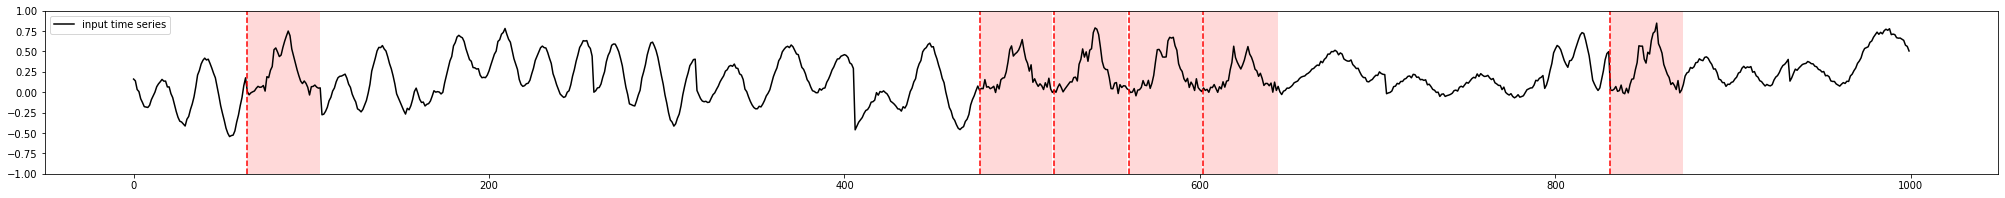

In [73]:
plt.figure(figsize=(35, 3))
#plt.plot(dist_list[:1000], label='distance to signature cycle')
plt.plot(ts_all[:1000], color='k', label='input time series')
plt.ylim(-1, 1)

for i in cycle_start:
    if i < 1000:
        plt.axvline(i, 0, 14, linestyle='--', color='r')
for i in range(len(cycle_start)):
    # alpha: 透明度
    # i+.5 -- 宽度
    if cycle_start.tolist()[i] <1000:
        plt.axvspan(cycle_start.tolist()[i], cycle_end.tolist()[i], facecolor='r', alpha=0.15)
plt.legend()

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...


Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 20}
Calculating prediction... prediction type:  proba


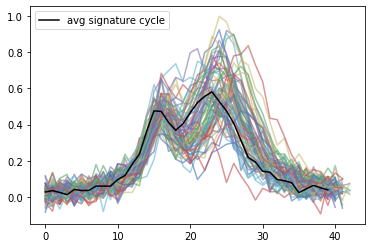

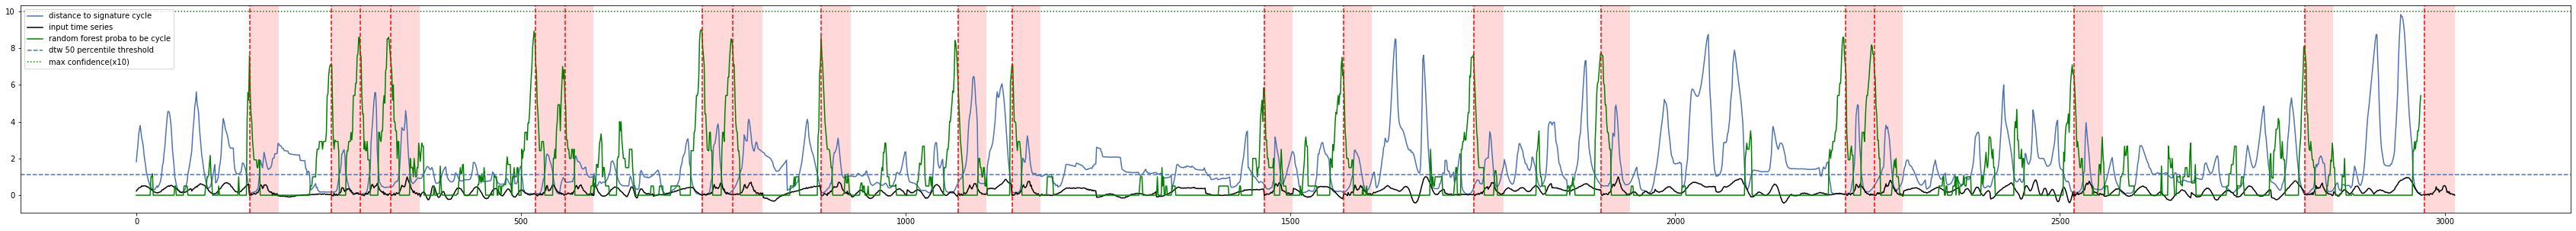

In [75]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'F_train_2.csv' 
test_file_name = 'F_test_2.csv'
target_name = 'B'
dtw_filter_percentile = 50
generate_report, generate_plot = True, True


print('Find signature cycle from training set ...')
signature2 = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results2 = sliding_window_find_dist(test_file_name, target_name, signature2)
ts_all2 = sliding_window_results2[0]
all_window_contents2 = sliding_window_results2[1]
dist_list2, path_list2 = sliding_window_results2[2], sliding_window_results2[3]
cycle_start2, cycle_end2 = sliding_window_results2[4], sliding_window_results2[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold2 = find_dtw_threshold(dist_list2, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list2 = sliding_window_classifier(all_window_contents2, dist_list2,
                                       train_file_name, target_name,
                                       suggested_threshold2)

plot_result(dist_list2, ts_all2, proba_list2,
            suggested_threshold2, cycle_start2, cycle_end2)

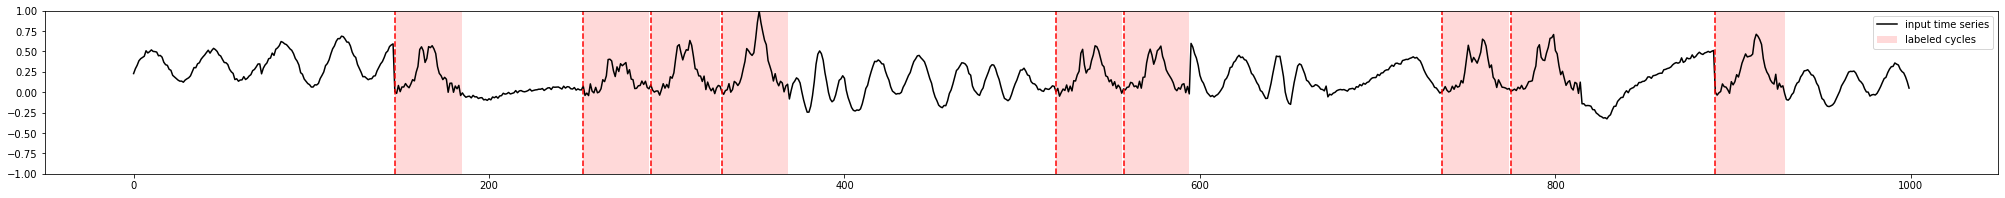

In [78]:
plt.figure(figsize=(35, 3))
#plt.plot(dist_list[:1000], label='distance to signature cycle')
plt.plot(ts_all2[:1000], color='k', label='input time series')
plt.ylim(-1, 1)

for i in cycle_start2:
    if i < 1000:
        plt.axvline(i, 0, 14, linestyle='--', color='r')
for i in range(len(cycle_start2)):
    # alpha: 透明度
    # i+.5 -- 宽度
    if cycle_start2.tolist()[i] <200:
        plt.axvspan(cycle_start2.tolist()[i], cycle_end2.tolist()[i], facecolor='r', label='labeled cycles', alpha=0.15)
    elif cycle_start2.tolist()[i] <1000:
        plt.axvspan(cycle_start2.tolist()[i], cycle_end2.tolist()[i], facecolor='r', alpha=0.15)
plt.legend()

In [ ]:
def performance_evaluator(predict_label, predict_timestamps, true_label, true_timestamps):
    

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance


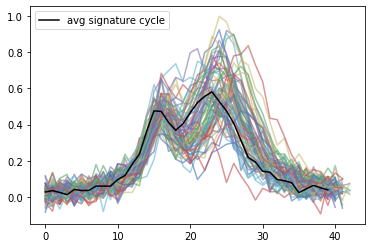

In [120]:
train_file_name = 'F_train_2.csv' 
test_file_name = 'F_test_2.csv'
target_name = 'B'
dtw_filter_percentile = 50
generate_report, generate_plot = True, True


print('Find signature cycle from training set ...')
signature2 = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results2 = sliding_window_find_dist(train_file_name, target_name, signature2)
ts_all2 = sliding_window_results2[0]
all_window_contents2 = sliding_window_results2[1]
dist_list2, path_list2 = sliding_window_results2[2], sliding_window_results2[3]
cycle_start2, cycle_end2 = sliding_window_results2[4], sliding_window_results2[5]

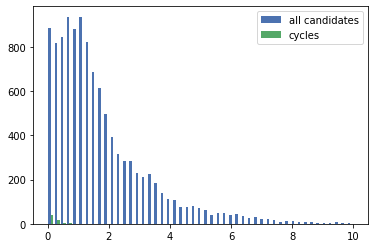

In [122]:
cycle_dist_list2 = []
for i in cycle_start2:
    cycle_dist_list2.append(dist_list2[i])

x = dist_list2
y = cycle_dist_list2
bins = np.linspace(0, 10, 50)

plt.hist([x, y], bins, label=['all candidates', 'cycles'])
plt.legend(loc='upper right')
plt.show()

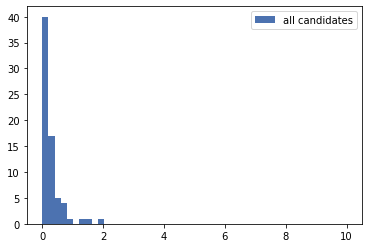

In [123]:
cycle_dist_list2 = []
for i in cycle_start2:
    cycle_dist_list2.append(dist_list2[i])

x = dist_list2
y = cycle_dist_list2
bins = np.linspace(0, 10, 50)

plt.hist(y, bins, label=['all candidates', 'cycles'])
plt.legend(loc='upper right')
plt.show()

In [125]:
def find_threshold_on_dist(dist_list, cycle_start):
    cycle_dist_list = []
    for i in cycle_start:
        cycle_dist_list.append(dist_list[i])
    
    return max(cycle_dist_list)

In [126]:
find_threshold_on_dist(dist_list2, cycle_start2)

1.8787069831363181

In [127]:
def find_threshold_on_proba(proba_list, cycle_start):
    cycle_proba_list = []
    for i in cycle_start:
        cycle_proba_list.append(proba_list[i])
    
    return min(proba_list)

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...


Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


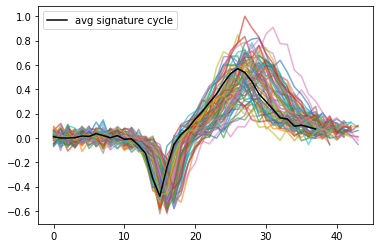

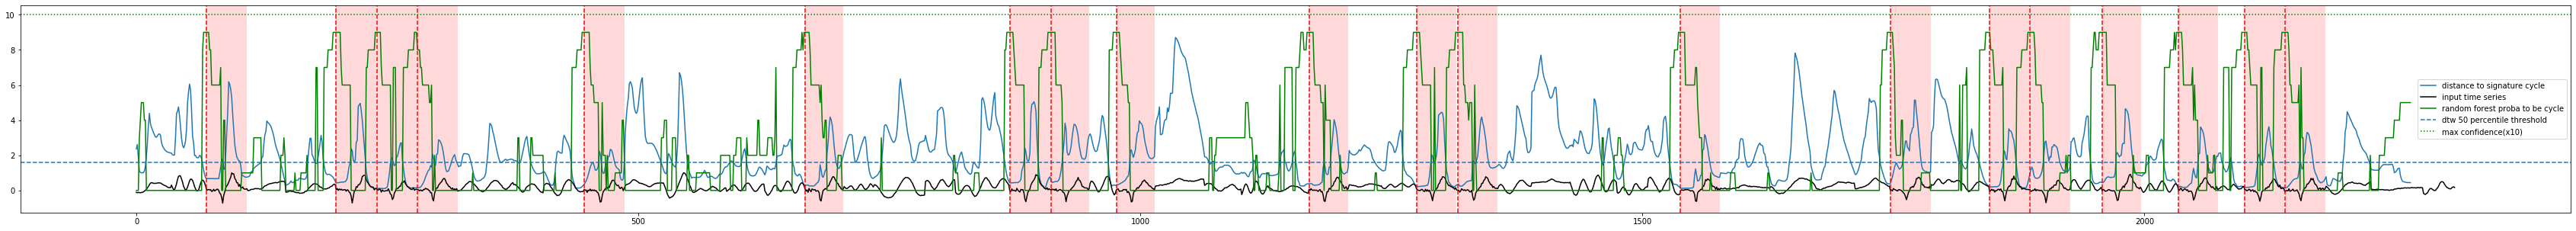

In [3]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'E_train_1.csv' 
test_file_name = 'E_test_2.csv'
target_name = 'B'
dtw_filter_percentile = 50
generate_report, generate_plot = True, True


print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)

In [191]:
suggested_threshold

1.5876933040993273

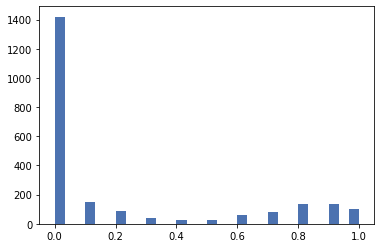

In [228]:
plt.hist(proba_list, bins=30)
plt.show()

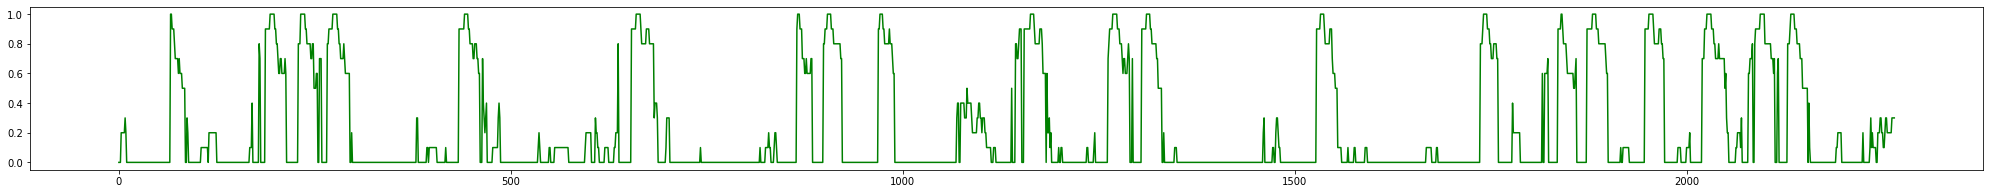

In [231]:
plt.figure(figsize=(35, 3))
plt.plot(proba_list, color='g')
plt.show()

In [249]:
def find_local_max(proba_list, threshold, range_filter):
    predicted_cycle_start, _ = find_peaks(proba_list, height=threshold, distance=range_filter)
    plt.figure(figsize=(35, 3))
    plt.plot(proba_list, color='g', alpha=0.6)
    for i in predicted_cycle_start:
        plt.axvline(i, 0, 14, color='b')
    plt.show()
    return predicted_cycle_start

In [253]:
-1 * np.array([1,2,3])

array([-1, -2, -3])

In [260]:
def find_local_min(dist_list, threshold, range_filter):
    
    predicted_cycle_start, _ = find_peaks(-1*np.array(dist_list), 
                                          height=-1*threshold, 
                                          distance=range_filter)
    plt.figure(figsize=(35, 3))
    plt.plot(dist_list, color='g', alpha=0.6)
    for i in predicted_cycle_start:
        plt.axvline(i, 0, 14, color='b')
    plt.show()
    return predicted_cycle_start

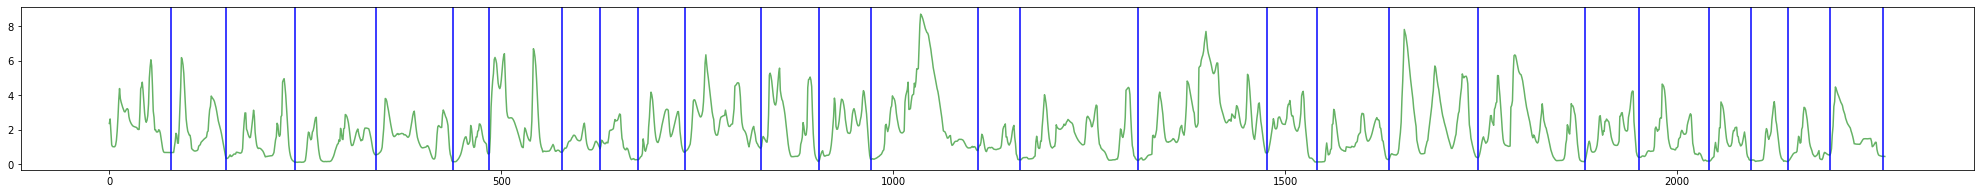

array([  79,  149,  237,  340,  438,  484,  577,  626,  674,  734,  831,
        905,  972, 1108, 1162, 1312, 1477, 1540, 1632, 1746, 1882, 1951,
       2041, 2094, 2141, 2195, 2263])

In [261]:
find_local_min(dist_list, threshold, range_filter)

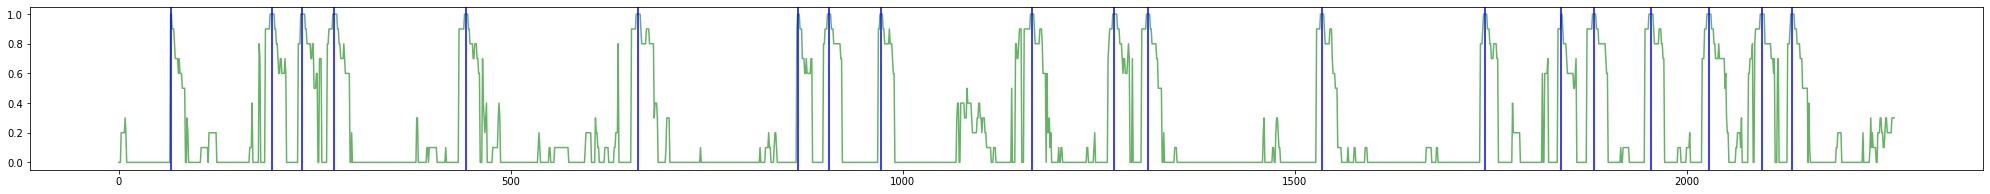

array([  66,  195,  234,  275,  443,  662,  867,  906,  972, 1165, 1270,
       1313, 1535, 1743, 1840, 1882, 1954, 2028, 2096, 2135])

In [262]:
threshold = 0.8
range_filter = 30
proba_filtered = []
find_local_max(proba_list, threshold, range_filter)

In [235]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [240]:
peaks, _ = find_peaks(proba_filtered, height=0.8, distance=30)
peaks

array([  66,  195,  234,  275,  443,  662,  867,  906,  972, 1165, 1270,
       1313, 1535, 1743, 1840, 1882, 1954, 2028, 2096, 2135])

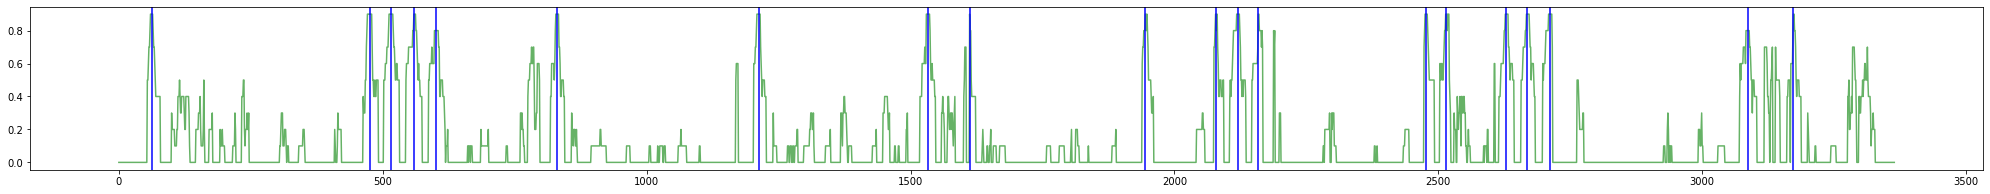

In [275]:
predicted_cycle_start, _ = find_peaks(proba_list, height=0.8, distance=38)

plt.figure(figsize=(35, 3))
plt.plot(proba_list, color='g', alpha=0.6)
for i in predicted_cycle_start:
    plt.axvline(i, 0, 14, color = 'b')
plt.show()

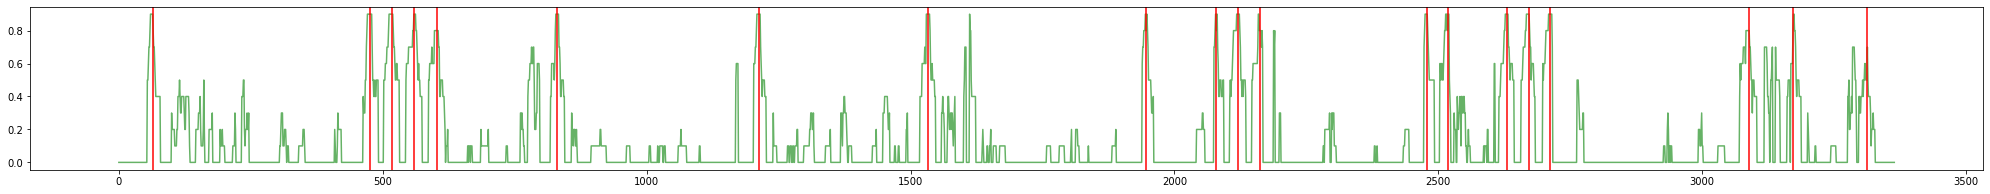

In [268]:
predicted_cycle_start, _ = find_peaks(proba_list, height=0.6, distance=30)

plt.figure(figsize=(35, 3))
plt.plot(proba_list, color='g', alpha=0.6)
for i in cycle_start.tolist():
    plt.axvline(i, 0, 14, color='r')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2310,) and (2266,)

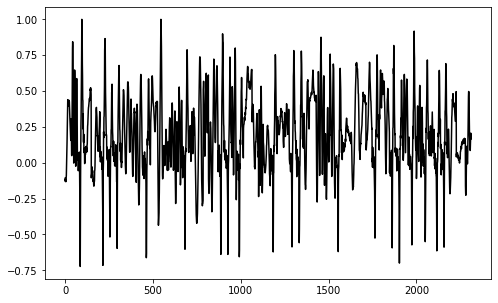

In [5]:
x = np.linspace(0,len(ts_all),len(ts_all))
y1 = ts_all
y2 = dist_list

z = proba_list

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x,y1, color='k', label='time series')

ax.plot(x, dist_list, label='distance to signature cycle')
ax.axhline(suggested_threshold, 0, 14, linestyle='--', label='DTW 50 percentile threshold')

# ax.axvline(54, 0, 14, linestyle='--')
# ax.axvline(79, 0, 14, linestyle='--')
# ax.axvline(100, 0, 14, linestyle='--')
# ax.axvline(135, 0, 14, linestyle='--')

# # ax.axvspan(54, 78, facecolor='y', alpha=0.15)
# ax.axvspan(100, 134, facecolor='y', alpha=0.15, label='region of classification')


#ax2 = ax.twinx()
#ax2.plot(x,proba_list[:150], color = 'g', label='proba of cycle')
fig.legend(loc="upper left")

ax.set_xlabel("x [units]")
ax.set_ylabel(r"time series input and DTW distance")
#ax.spines['left'].set_color('b')
ax2.set_ylabel(r"proba of cycle", color='g')
#ax2.spines['right'].set_color('g')
plt.show()